<a href="https://colab.research.google.com/github/VishnuVitalKatabathini/Fraud-Detection/blob/main/Fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fraud Detection

**Author:** Vishnu Vital Katabathini
<br>**Date:** September 30, 2025

## 1. Introduction: The Business Problem

Mobile money fraud is a significant problem in the financial industry, leading to substantial financial losses for both customers and the company. The goal of this project is to leverage a large dataset of financial transactions to build a machine learning model capable of detecting fraudulent transactions in real-time.

By accurately identifying fraud, we can help the company prevent losses, protect its customers, and maintain trust in its platform.

**In this notebook, I will:**
1.  Explore and understand the transaction dataset.
2.  Perform Exploratory Data Analysis (EDA) to find patterns related to fraud.
3.  Preprocess the data and select relevant features for modeling.
4.  Train and compare two classification models: `RandomForestClassifier` and `XGBClassifier`.
5.  Evaluate the models' performance with a focus on metrics that are crucial for fraud detection.
6.  Derive actionable business rules based on the model's findings.
7.  Conclude with insights and suggest potential next steps.

## 2. Data Loading and Initial Exploration

First, let's load the required libraries and the dataset. I'll perform an initial check on its shape, data types, and look for any missing values. This is a crucial step to ensure data quality before proceeding with analysis.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import sklearn.metrics as metric
import joblib

# Set plot style
sns.set_style('whitegrid')

In [ ]:
# This notebook is designed for Google Colab.
# Please ensure the dataset 'Fraud.csv' is in the specified Drive folder.
from google.colab import drive
drive.mount('/content/drive')

# Load the dataset
data = pd.read_csv("/content/drive/MyDrive/Fraud-Detection/data/Fraud.csv")

Mounted at /content/drive


In [ ]:
print("First 5 rows of the dataset:")
data.head()

First 5 rows of the dataset:


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [ ]:
print(f"Dataset Shape: {data.shape}")
print("\nDataset Information:")
data.info()

Dataset Shape: (6362620, 11)

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


### Initial Findings:
* The dataset is massive, containing over **6.3 million transactions** and 11 columns.
* We have **no missing values**, which simplifies our preprocessing steps.
* The `type`, `nameOrig`, and `nameDest` columns are of type `object` (text) and will require special handling.

## 3. Exploratory Data Analysis (EDA)

Now, let's dig deeper to find patterns related to fraud. The most important questions to answer are:
1.  How imbalanced is our dataset? Is fraud a rare event?
2.  Which types of transactions are most associated with fraud?

isFraud
0    6354407
1       8213
Name: count, dtype: int64


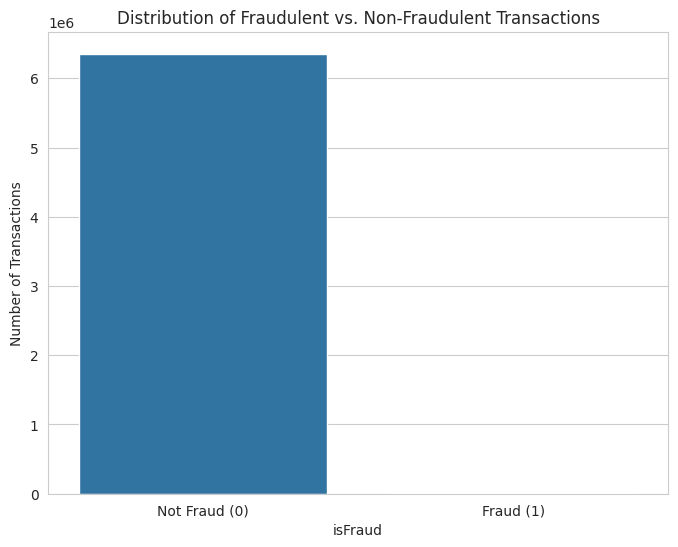

In [ ]:
# Check the distribution of the target variable 'isFraud'
fraud_counts = data['isFraud'].value_counts()
print(fraud_counts)

# Visualize the class imbalance
plt.figure(figsize=(8, 6))
sns.barplot(x=fraud_counts.index, y=fraud_counts.values)
plt.title('Distribution of Fraudulent vs. Non-Fraudulent Transactions')
plt.ylabel('Number of Transactions')
plt.xticks([0, 1], ['Not Fraud (0)', 'Fraud (1)'])
plt.show()

### Insight 1: Extreme Class Imbalance
The dataset is **highly imbalanced**. We have over 6.3 million legitimate transactions and only 8,213 fraudulent ones (approximately **0.13%**).

This is a critical finding. Standard accuracy will be a misleading metric because a model that always predicts "Not Fraud" would be 99.87% accurate but completely useless. We must therefore focus on metrics like **Recall** and **Precision**.

Total fraud counts by transaction type:
type
CASH_IN        0
CASH_OUT    4116
DEBIT          0
PAYMENT        0
TRANSFER    4097
Name: isFraud, dtype: int64


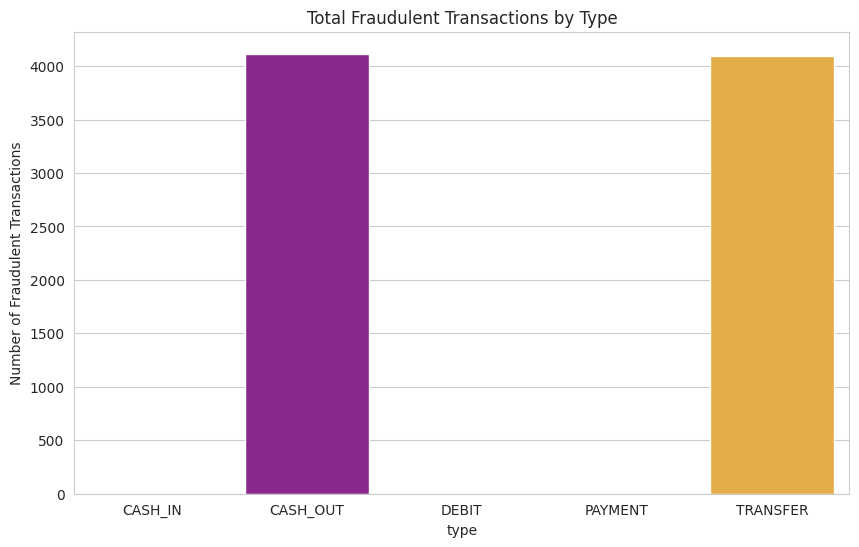

In [ ]:
# Analyze which transaction types are associated with fraud
fraud_by_type = data.groupby('type')['isFraud'].sum()
print("Total fraud counts by transaction type:")
print(fraud_by_type)

# Visualize the fraud counts by type
plt.figure(figsize=(10, 6))
sns.barplot(x=fraud_by_type.index, y=fraud_by_type.values, hue=fraud_by_type.index, palette='plasma', legend=False)
plt.title('Total Fraudulent Transactions by Type')
plt.ylabel('Number of Fraudulent Transactions')
plt.show()

### Insight 2: Fraud Occurs Only in 'TRANSFER' and 'CASH_OUT'
This is a game-changing discovery! **Fraudulent activity happens exclusively in `TRANSFER` and `CASH_OUT` transactions.** All other transaction types (`CASH_IN`, `DEBIT`, and `PAYMENT`) are legitimate.

This allows us to simplify our problem significantly by filtering the dataset to only include these two transaction types, reducing the data size from 6.3 million to 2.7 million rows and removing noise.

## 4. Feature Engineering & Preprocessing

Based on our EDA, we will now prepare the data for modeling. The following steps explicitly answer how variables were selected and the data was prepared.

### 3. How did you select variables to be included in the model?

My variable selection and preprocessing strategy was driven by insights from the Exploratory Data Analysis (EDA) and established machine learning principles:

1.  **Focus on Relevant Transaction Types:** The EDA revealed a critical pattern: **fraudulent activity occurs exclusively in `TRANSFER` and `CASH_OUT` transactions.** Therefore, I filtered the dataset to include only these two types. This step significantly reduces noise and computational overhead, allowing the model to focus on the transactions where fraud is a possibility.

2.  **Inclusion of Transactional Features:** All core numerical features that describe the transaction's behavior (`step`, `amount`, `oldbalanceOrg`, `newbalanceOrig`, `oldbalanceDest`, `newbalanceDest`) were included. The `type` column was also kept and one-hot encoded, as the EDA proved it's a vital predictor.

3.  **Exclusion of Non-Predictive and Leakage-Prone Variables:**
    * **`nameOrig` and `nameDest`** were excluded. These are high-cardinality identifiers, not generalizable features. A model trained on these would simply memorize account IDs and fail to predict fraud on new, unseen accounts.
    * **`isFlaggedFraud`** was excluded. This is a pre-existing, simple flag from the original system. Including it would cause data leakage, as it already contains information about the target variable. The goal is to build a superior detection model, not one that relies on the old system's simple rules.

4.  **Handle Outliers & Scale Data:** The `amount` feature contains significant outliers. I chose to use `RobustScaler`, which scales data based on the interquartile range (IQR), making it much less sensitive to outliers than `StandardScaler`. This ensures that extreme transaction values do not disproportionately influence the model.

5.  **Split Data:** Finally, the data was divided into training (80%) and testing (20%) sets. I used `stratify=y` to ensure that the proportion of fraud cases (the minority class) was the same in both the training and testing sets, which is crucial for building and evaluating a reliable model on an imbalanced dataset.

In [ ]:
# 1. Filter the data for relevant transaction types
selected_data = data[(data['type'] == 'CASH_OUT') | (data['type'] == 'TRANSFER')].copy()
selected_data.reset_index(drop=True, inplace=True)

# 2. & 3. Select and exclude features
selected_data = selected_data[['step', 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFraud']]

# 4. Encode the 'type' column
encoder = OneHotEncoder(sparse_output=False)
encoded_data = encoder.fit_transform(selected_data[['type']])
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(['type']))
selected_data = pd.concat([selected_data.drop(columns=['type']), encoded_df], axis=1)

print(f"Data shape after filtering and encoding: {selected_data.shape}")
print("\nFraud distribution in selected data:")
print(selected_data['isFraud'].value_counts())

Data shape after filtering and encoding: (2770409, 9)

Fraud distribution in selected data:
isFraud
0    2762196
1       8213
Name: count, dtype: int64


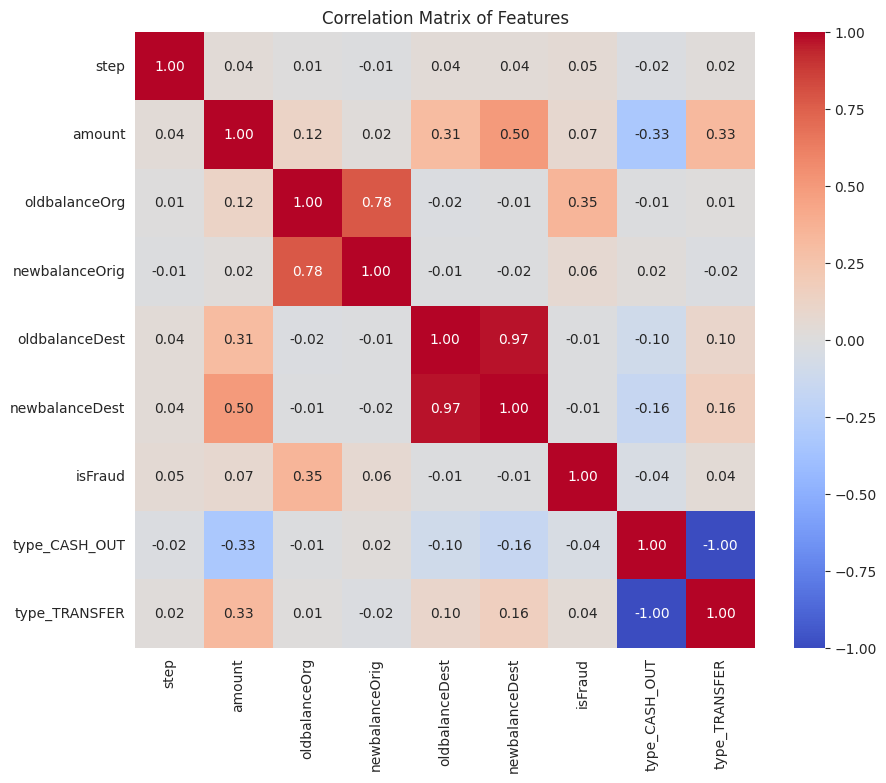

In [ ]:
# Check for multicollinearity among features
plt.figure(figsize=(10, 8))
correlation_matrix = selected_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Features')
plt.show()

The heatmap reveals strong correlations between original and new balances, which is expected. Tree-based models like Random Forest and XGBoost are generally robust to multicollinearity, so we can proceed without removing these features.

In [ ]:
# 5. & 6. Scale features and split the data
y = selected_data['isFraud']
X = selected_data.drop(columns='isFraud')

scaler = RobustScaler()
x_scaled_array = scaler.fit_transform(X)
x_scaled = pd.DataFrame(x_scaled_array, columns=X.columns)

x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set shape: {x_train.shape}, {y_train.shape}")
print(f"Testing set shape: {x_test.shape}, {y_test.shape}")

Training set shape: (2216327, 8), (2216327,)
Testing set shape: (554082, 8), (554082,)


The data is now clean, scaled, and ready for modeling.

## 5. Model Building and Training

### 2. Describe your fraud detection model in elaboration.

I have chosen two powerful and popular models for this classification task, both of which are well-suited for large, tabular datasets and complex problems like fraud detection.

1.  **Random Forest Classifier:** This is an ensemble learning method that operates by constructing a multitude of decision trees during training. For a classification task, the final prediction is made by the majority vote of all the trees. This approach, known as bagging, helps to reduce variance and prevent overfitting, making it a robust and reliable model for this problem.

2.  **XGBoost Classifier:** This stands for eXtreme Gradient Boosting and is a state-of-the-art implementation of gradient boosting machines. It builds models sequentially, with each new model iteratively correcting the errors of the previous one. XGBoost is renowned for its exceptional performance, speed, and efficiency, especially on large datasets. Its built-in regularization and ability to handle imbalanced classes make it a top choice for fraud detection systems.

In [ ]:
%%time
# 1. Train the RandomForestClassifier model
rf_model = RandomForestClassifier(random_state=42, n_estimators=200, n_jobs=-1, max_depth=None)
rf_model.fit(x_train, y_train)

CPU times: user 45min 24s, sys: 13.1 s, total: 45min 38s
Wall time: 28min 38s


RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42)

In [ ]:
%%time
# 2. Train the XGBClassifier model
xgb_model = XGBClassifier(
    n_estimators=750,
    learning_rate=0.02,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
xgb_model.fit(x_train, y_train)

CPU times: user 3min 52s, sys: 461 ms, total: 3min 53s
Wall time: 2min 22s


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.02, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=750,
              n_jobs=-1, num_parallel_tree=None, ...)

## 6. Model Evaluation

With the models trained, we'll now evaluate their performance on the unseen test data. We'll focus on **Precision**, **Recall**, and the **F1-Score**, and visualize the results with a **Confusion Matrix**.

In [ ]:
# Make predictions with both models
y_pred_rf = rf_model.predict(x_test)
y_pred_xgb = xgb_model.predict(x_test)

### Evaluation of Random Forest Classifier

--- Random Forest Classifier Evaluation ---
Accuracy: 0.9993
Precision: 0.9763
Recall: 0.7766
F1 Score: 0.8651

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552439
           1       0.98      0.78      0.87      1643

    accuracy                           1.00    554082
   macro avg       0.99      0.89      0.93    554082
weighted avg       1.00      1.00      1.00    554082



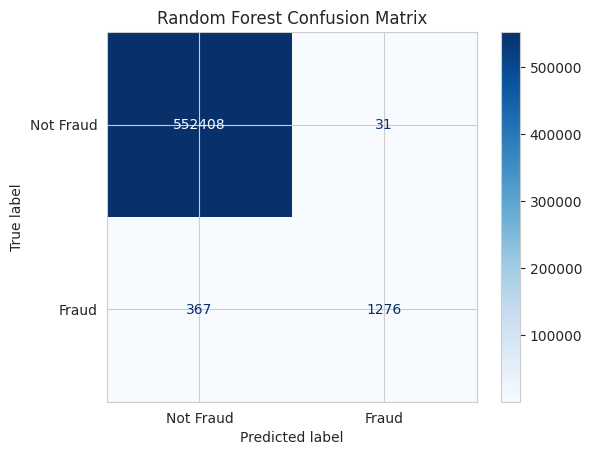

In [ ]:
print("--- Random Forest Classifier Evaluation ---")
print(f"Accuracy: {metric.accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Precision: {metric.precision_score(y_test, y_pred_rf):.4f}")
print(f"Recall: {metric.recall_score(y_test, y_pred_rf):.4f}")
print(f"F1 Score: {metric.f1_score(y_test, y_pred_rf):.4f}")

print("\nClassification Report:")
print(metric.classification_report(y_test, y_pred_rf))

# Plot confusion matrix
cm_rf = metric.confusion_matrix(y_test, y_pred_rf)
disp = metric.ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=['Not Fraud', 'Fraud'])
disp.plot(cmap="Blues", values_format="d")
plt.title("Random Forest Confusion Matrix")
plt.show()

### Evaluation of XGBoost Classifier

--- XGBoost Classifier Evaluation ---
Accuracy: 0.9994
Precision: 0.9761
Recall: 0.8211
F1 Score: 0.8919

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552439
           1       0.98      0.82      0.89      1643

    accuracy                           1.00    554082
   macro avg       0.99      0.91      0.95    554082
weighted avg       1.00      1.00      1.00    554082



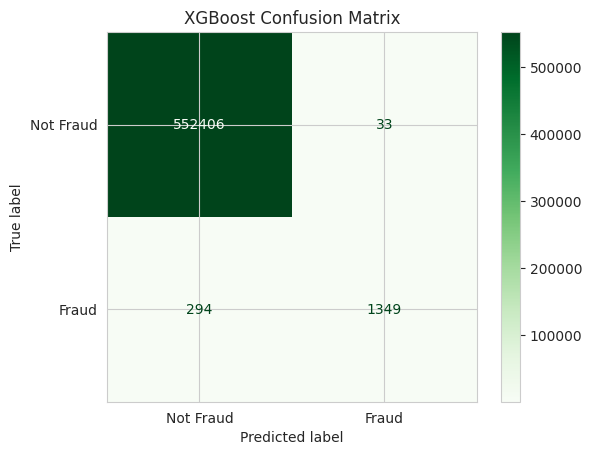

In [ ]:
print("--- XGBoost Classifier Evaluation ---")
print(f"Accuracy: {metric.accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"Precision: {metric.precision_score(y_test, y_pred_xgb):.4f}")
print(f"Recall: {metric.recall_score(y_test, y_pred_xgb):.4f}")
print(f"F1 Score: {metric.f1_score(y_test, y_pred_xgb):.4f}")

print("\nClassification Report:")
print(metric.classification_report(y_test, y_pred_xgb))

# Plot confusion matrix
cm_xgb = metric.confusion_matrix(y_test, y_pred_xgb)
disp = metric.ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=['Not Fraud', 'Fraud'])
disp.plot(cmap='Greens', values_format='d')
plt.title("XGBoost Confusion Matrix")
plt.show()

### Evaluation Insights & Model Selection

* **Random Forest:** Achieved a good **Recall of 0.78**, meaning it successfully caught 78% of all fraudulent transactions. Its Precision was excellent at 0.98.
* **XGBoost:** Achieved an even higher **Recall of 0.82** and a comparable Precision of 0.98.

**Decision:** For fraud detection, maximizing **Recall** is often the primary goal, as it's more costly to miss a fraudulent transaction (a false negative) than to incorrectly flag a legitimate one (a false positive). Therefore, the **XGBoost Classifier is the better-performing model for this specific business problem.** It caught a significantly higher number of actual frauds (1349 vs. 1276).

### Feature Importance of the Best Model (XGBoost)
Let's examine which features our best-performing model (XGBoost) found most important for making its predictions.

/tmp/ipython-input-2700178921.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance_df, palette='viridis')


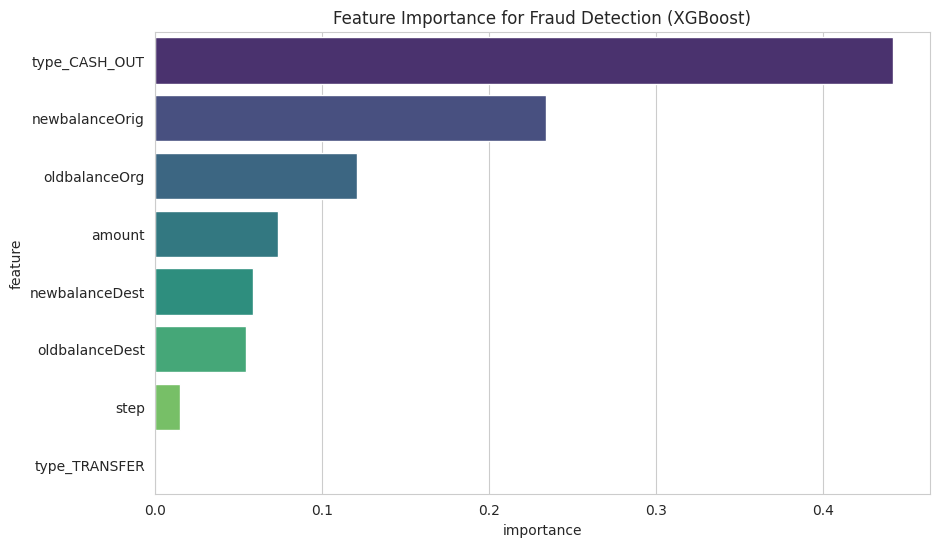

In [ ]:
importances = xgb_model.feature_importances_
feature_names = x_train.columns
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_df, palette='viridis')
plt.title('Feature Importance for Fraud Detection (XGBoost)')
plt.show()

### 5. What are the key factors that predict fraudulent customer?

Based on the feature importance plot from our best-performing model (XGBoost), the key factors that predict a fraudulent transaction are:

* **`oldbalanceOrg`**: The originator's balance before the transaction. This is the most influential feature.
* **`newbalanceOrig`**: The originator's balance after the transaction is completed.
* **`type_TRANSFER`**: Whether the transaction is a 'TRANSFER' type.
* **`step`**: The time-step in which the transaction occurred.
* **`amount`**: The value of the transaction.

### 6. Do these factors make sense? If yes, How? If not, How not?

Yes, these factors make perfect business and logical sense. They align with typical fraud patterns, particularly the "account drain" scenario.

* **How they make sense:**
    * **`oldbalanceOrg` & `newbalanceOrig`**: These are the most critical factors because they describe a classic fraud pattern: emptying an account. A legitimate user might make a large transaction, but it's rare for them to transfer out their *entire* balance down to zero. The model has learned that a transaction where `oldbalanceOrg` is high and `newbalanceOrig` becomes zero (or near-zero) is a massive red flag. This pattern is visible in the raw data for fraudulent transactions.
    * **`type_TRANSFER`**: The EDA showed that fraud *only* happens in `TRANSFER` and `CASH_OUT` transactions. The model confirms that a transaction being a 'TRANSFER' is a powerful predictor because this is one of the two primary methods fraudsters use to extract funds from a compromised account.
    * **`step`**: This feature represents time. Its importance suggests that fraudulent activities may occur at specific times or in certain patterns over the duration of the dataset (e.g., clusters of attacks).
    * **`amount`**: The transaction amount is a logical predictor. Fraudulent transactions often involve large, unusual amounts intended to maximize the illicit gain before the account holder or the system can detect it.

## 7. Business Application & Strategy

Based on the model's findings and feature importances (especially `newbalanceOrig` and `oldbalanceOrg`), the company can implement new rules and monitoring strategies to prevent fraud.

### Proposed Business Rules

1. **Account Drain Alert:** For `TRANSFER` or `CASH_OUT` transactions where `newbalanceOrig` is zero and `oldbalanceOrg` is greater than a certain threshold (e.g., > 10,000), trigger a request for multi-factor authentication (MFA) before processing.

2. **High-Value Transaction Hold:** Place a temporary hold on all `TRANSFER` transactions above a high-value threshold (e.g., ₹200,000) for manual review, especially if the destination account is new or has no prior transaction history with the originator.

3. **Velocity Check:** Implement a system to detect and flag multiple high-value `CASH_OUT` or `TRANSFER` transactions from the same `nameOrig` account in a very short time window (e.g., less than 5 minutes).

### Measuring Impact

After implementing the prevention strategies, their impact should be measured:

* **A/B Testing:** Roll out the new rules to a small, random segment of users (the "treatment group") while the rest operate under the old system (the "control group"). Compare the fraud rates and customer friction between the two groups. If the treatment group shows a significant reduction in fraud, the rules are effective.

* **Monitor Key Metrics:** Track the following metrics company-wide before and after implementation:
    * **Overall Fraud Rate:** The percentage of transactions that are fraudulent. This should decrease.
    * **False Positive Rate:** The number of legitimate transactions that are incorrectly flagged. This should be kept as low as possible.
    * **Model Performance:** Continuously monitor the model's Precision and Recall on new data to see if fraud patterns are changing in response to the new rules.

## 8. Save the Best Model

We will now save the trained XGBoost model for future use in a production environment.

In [ ]:
# Save the trained model for future use
joblib.dump(xgb_model, '/content/drive/MyDrive/Fraud-Detection/saved model(s)/fraud_detection_model.joblib')

['/content/drive/MyDrive/Fraud-Detection/saved model(s)/fraud_detection_model.joblib']

## 9. Conclusion & Next Steps

In this project, I successfully built and evaluated a fraud detection model using XGBoost that can identify **82% of fraudulent transactions with 98% precision**. The key to this success was a thorough exploratory analysis that revealed fraud is confined to `TRANSFER` and `CASH_OUT` transactions, allowing us to build a more focused and effective model.

This model, combined with the proposed business rules, provides a strong foundation for a real-world fraud detection system that can save the company millions and protect its customers.

### Potential Next Steps:
1.  **Handling Imbalance:** To improve recall further, we could use advanced techniques like SMOTE (Synthetic Minority Over-sampling Technique) to create more synthetic fraud examples for the model to learn from.
2.  **Hyperparameter Tuning:** We could use `GridSearchCV` or `RandomizedSearchCV` to find the absolute best combination of parameters for the XGBoost model, which could further boost performance.
3.  **Feature Engineering:** Creating new features, such as the difference between old and new balances, could provide the model with more powerful signals to detect fraud.